# Tutorial 1: Approximate MNIST
This notebook will walk you through the steps required to train a simple CNN on the MNIST dataset while determining the robustness to additive Gaussian noise.

`agnapprox` already comes with predefined implementations for an MNIST dataset loader as well as [LeNet5](https://en.wikipedia.org/wiki/LeNet) which we will use in this tutorial. The next tutorial will show you how to define your own architecture.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from agnapprox.nets import LeNet5
from agnapprox.datamodules import MNIST

No CUDA device detected. Running on CPU.


We first set up the datamodule. Downloaded datasets are written to the path pointed to by the environment variable `AGNAPPROX_DATA_DIR` by default. If the variable is not set, the subdirectory `data` is created locally.

In [3]:
dm = MNIST(batch_size=128, num_workers=4)
dm.prepare_data()
dm.setup()

Next, we define the model. We can simply instantiate the appropriate `agnapprox` wrapper without anything else.

In [4]:
model = LeNet5()

## Model Training

Every `agnapprox` network has four modes in which the network can be trained:
1. **Baseline**: Train an FP32 baseline model without quantization, approximation, AGN, etc.
2. **Quantization-aware Training**: Apply quantization during the forward pass. Also known as _quantization-aware training_
3. **Gradient Search**: Add Gaussian noise to the output of each target operation. The amount of noise injected in each layer is passed to the optimizer and optimized together with the other network parameters.
4. **Approximate Retraining**: Use Lookup tables of approximate multipliers to retrain the network in order to minimize the loss of accuracy when deploying approximate multipliers

Normally, you would train a model in every mode in the order given above (but feel free to experiment with other setups!). `agnapprox` network instances provide training functions for each mode with some added functionality. The training functions are wrappers around `pytorch-lightning`'s `Trainer()` API and extra arguments can be passed to the `fit()` method if desired.

We will start with a simple FP32 baseline model. The default number of epochs for each stage is defined in the network wrapper file, but it can be overridden by passing `epochs=` to the training function. Here, we will train for 8 epochs.

In [5]:
model.train_baseline(dm, test=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | LeNet5 | 61.9 K
---------------------------------
61.9 K    Trainable params
0         Non-trainable params
61.9 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc_top1         0.9876999855041504
        test_loss           0.04124484583735466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Next, we optimze the model for 8-Bit quantization using the `train_quant` functions. If you are wondering where the training hyperparameters like optimizer, learning rate, learning rate schedule etc. are coming from: They are also pre-defined in the network's definition.

In [6]:
model.train_quant(dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | LeNet5 | 61.9 K
---------------------------------
61.9 K    Trainable params
0         Non-trainable params
61.9 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Robustness Optimization

Now comes the exciting part: We train while optimizing the amoung of AGN per layer. By passing `verbose=True` we get a debug output with the intermediate results after every epoch.

In [7]:
# Set appropriate log level and send to stdout so that logging output shows up in Jupyter
import logging
import sys
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

model.train_gradient(dm, lmbd=0.2, initial_noise=0.025)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | LeNet5 | 61.9 K
---------------------------------
61.9 K    Trainable params
0         Non-trainable params
61.9 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:agnapprox.nets.approxnet:Epoch: 0
INFO:agnapprox.nets.approxnet:Layer: model.conv1.0 | sigma_l: +0.151
INFO:agnapprox.nets.approxnet:Layer: model.conv2.0 | sigma_l: +0.306
INFO:agnapprox.nets.approxnet:Layer: model.linear1 | sigma_l: +0.058
INFO:agnapprox.nets.approxnet:Layer: model.linear2 | sigma_l: +0.027
INFO:agnapprox.nets.approxnet:Layer: model.linear3 | sigma_l: +0.009


`Trainer.fit` stopped: `max_epochs=1` reached.


## Multiplier Assignment
Finally, we can use this information to assign matching multipliers to each layer.
This is done through a helper function that gets passed a list of approximate multipliers, from which the best-matching one is picked for each layer.

Each multiplier in the list should be a dataclass instance that looks like this:
```python
@dataclass
class ApproximateMultiplier
    name: str
    performance_metric: float
    error_map: np.ndarray
```
For the parameter `performance_metric`, you can choose any property that you want to **minimize** across the your neural network. Normally, this would likely be things like power consumption, area usage, etc.

### Error Map Construction
The `error_map` is a numpy array of shape 256x256, where each entry corresponds to the difference between the accurate and the approximate result for `int8` operands:
```python
error_map = np.empty([256,256])

for x in range(-128, 128):
    for y in range(-128, 128):
        error_map[x+128][y+128] = x * y - approx_mult(x, y)
```
Where `approx_mult` is some approximate multiplication implementation.

In [8]:
# Import a few helpers and a provider of approximate multipliers
from agnapprox.utils import select_multipliers, deploy_multipliers
from agnapprox.libs.evoapprox import EvoApprox
import pytorch_lightning as pl

trainer = pl.Trainer()
evo = EvoApprox()

print(", ".join([tm.name for tm in evo.search_space()]))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


mul8s_1KV6, mul8s_1KV8, mul8s_1KV9, mul8s_1KVA, mul8s_1KVM, mul8s_1KVP, mul8s_1KVQ, mul8s_1KX5, mul8s_1KXF, mul8s_1L12, mul8s_1L2J, mul8s_1L2L, mul8s_1L2N


In [9]:
# Match multipliers to layers
res = select_multipliers(
    model, dm, evo.search_space(), trainer
)
# Deploy selected multipliers to each layer
deploy_multipliers(model, res, evo)

Validation: 0it [00:00, ?it/s]

INFO:agnapprox.utils.select_multipliers:Layer: model.conv1.0, Best Match: mul8s_1L2N, Performance: 0.126000, Relative Performance: 0.296471
INFO:agnapprox.utils.select_multipliers:Layer: model.conv2.0, Best Match: mul8s_1L2N, Performance: 0.126000, Relative Performance: 0.296471
INFO:agnapprox.utils.select_multipliers:Layer: model.linear1, Best Match: mul8s_1KXF, Performance: 0.237000, Relative Performance: 0.557647
INFO:agnapprox.utils.select_multipliers:Layer: model.linear2, Best Match: mul8s_1KX5, Performance: 0.289000, Relative Performance: 0.680000
INFO:agnapprox.utils.select_multipliers:Layer: model.linear3, Best Match: mul8s_1KVQ, Performance: 0.351000, Relative Performance: 0.825882


If we look at some data, we see that the layer with the most multiplications gets assigned the hardware instance with the lowest energy consumption, while the first and last layers remain relatively accurate.

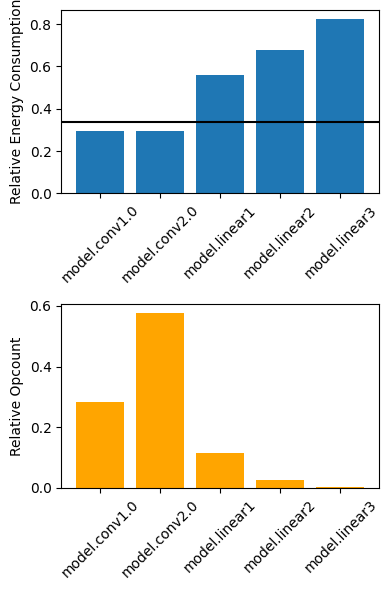

In [10]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(len(res.layers))
multiplier_performance = np.array([l.relative_energy_consumption(res.metric_max) for l in res.layers])
opcounts = np.array([l.relative_opcount(res.opcount) for l in res.layers])
labels = [l.name for l in res.layers]

plt.figure(figsize=(4,6))
plt.subplot(211)
plt.bar(x, multiplier_performance)
plt.xticks(x, labels, rotation=45)
plt.ylabel('Relative Energy Consumption')
plt.axhline(res.relative_energy_consumption, color='black')

plt.subplot(212)
plt.bar(x, opcounts, color='orange')
plt.xticks(x, labels, rotation=45)
plt.ylabel('Relative Opcount')
plt.tight_layout()
plt.show()

## Approximate Retraining

We have selected an approximate multiplier for each layer and deployed them. The last step is to retrain the network while simulating the selected approximate multipliers so that the network learns to compensate for the error.

In [11]:
model.train_approx(dm, test=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | LeNet5 | 61.9 K
---------------------------------
61.9 K    Trainable params
0         Non-trainable params
61.9 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=0` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc_top1         0.5393000245094299
        test_loss           1.6119410991668701
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Uniform approximation

Finally, we can compare that to a uniform solution where the same approximate multiplier is used across all layers

In [14]:
for n,m in model.noisy_modules:
    m.approx_op.lut = evo.load_lut('mul8s_1L2L')

model.train_approx(dm, test=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | LeNet5 | 61.9 K
---------------------------------
61.9 K    Trainable params
0         Non-trainable params
61.9 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/elias/agn-approx/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc_top1         0.9818000197410583
        test_loss           0.06068200618028641
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Depending on your initialization, the uniform solution might sometimes end up having a slightly better accuracy compared to the heterogeneous solution. This is because MNIST is an extremely simple problem and this notebook does not used hyperparameters that are particularly well-tuned.